# Colorectal Histology

#### Gökay Berkem TURAN
#### Zafer Can YÜCEL

In this project, we will make a classification using a [Colorectal Histology MNIST Dataset](https://www.kaggle.com/kmader/colorectal-histology-mnist) consisting of 8 different types of tissues taken from colorectal cancer patients. We will use deep learning models to make this classification. We will make classification with four different CNN models and compare their results. We will calculate accuracy using the ratio of correct predictions to total predictions to evaluate the success of the classification.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Although the images used in pathological examinations are high-resolution images, problems arise in the classification of tissues by humans because the tissues are micro-sized. Since such issues are directly related to human health, the diagnosis process of the disease should be more precise. Therefore, it is necessary to increase the accuracy of the diagnosis of the disease.  We will use deep learning models to eliminate these problems and facilitate the classification of tissues.

## Data Understanding<a class="anchor" id="data_understanding"></a>

In this project, we are using the [Colorectal Histology MNIST Dataset](https://www.kaggle.com/kmader/colorectal-histology-mnist). This dataset is a dataset consisting of 8 classes (TUMOR, STROMA, COMPLEX, LYMPHO, DEBRIS, MUCOSA, ADIPOSE, EMPTY) and 5000 images. The image resolution in the dataset is 150x150 pixels. Class distribution in the dataset is equal. There are 625 images in each class. All images in the dataset are in RGB format.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.utils.data
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
from torchvision.transforms import transforms
from torchvision import transforms, models
import warnings
import seaborn as sns
import matplotlib.pyplot as pltt
import pandas as pd
import cv2
from PIL import Image
warnings.filterwarnings("ignore")
#  Device config
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
print(torch.cuda.get_device_name(0))

Device:  cuda:0
Tesla T4


## Data Preparation<a class="anchor" id="data_preparation"></a>

We converted the images in our dataset from tif format to jpg format. We split our dataset into 70% train, 15% test and 15% validation. You can access the split version of the dataset from the [link here](https://drive.google.com/drive/folders/1Y1IlZ4Tkuf72R3p1ydmfnSgb1mLs6wSc). Our dataset includes 3512 train, 744 test and 744 validation images. Each class has 439 train, 93 test and 93 validation images. We used train data while training our model, we used validation data while setting the hyperparameters of our models. While testing our model with unseen data, we measured the success of our model using test data. Since our dataset does not contain too many images, it is possible for our model to learn the detail and noise in the training data and this situation causes overfitting. We need to diversify the data we have in order to prevent overfitting and increase accuracy. If we do not have enough data, we can do data diversification by using data augmentation method. We used the class "transforms" in the PyTorch library to do data augmentation. We used data augmentation only for train data. For the train data, we resized the images to 224x224, applied random horizontal flip, random vertical flip, random rotation, and normalized the images. For test and validation data, we resized the images to be 224x224 - the input size of the CNN models we use - and normalized the images.

In [3]:
transformed = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transformations_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

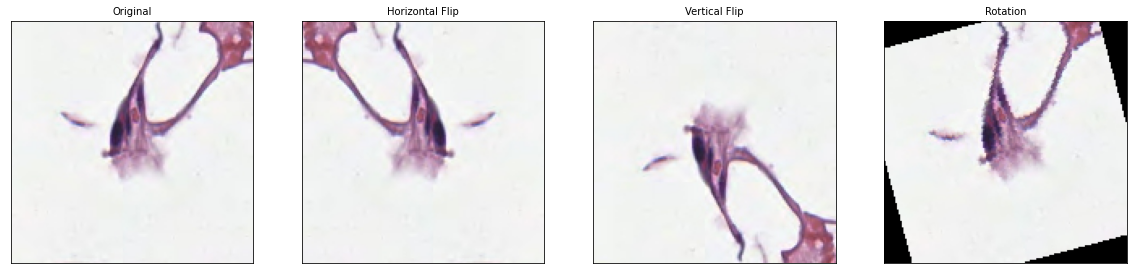

In [5]:
fig, ax = plt.subplots(1,4, figsize= (20,5))
image = Image.open('/content/drive/MyDrive/BBM469-Project/Dataset_469/train/07_ADIPOSE/12B5F_CRC-Prim-HE-05_032.jpg')
ax[0].imshow(image)
ax[0].set_title('Original', fontsize = 10)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(transforms.functional.hflip(image))
ax[1].set_title('Horizontal Flip', fontsize = 10)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[2].imshow(transforms.functional.vflip(image))
ax[2].set_title('Vertical Flip', fontsize = 10)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

ax[3].imshow(transforms.functional.rotate(image,15))
ax[3].set_title('Rotation', fontsize = 10)
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
plt.show()

<h4>Data Loader</h4>

In [4]:
train_path = '/content/drive/MyDrive/BBM469-Project/Dataset_469/train'
validation_path = '/content/drive/MyDrive/BBM469-Project/Dataset_469/val'
test_path = '/content/drive/MyDrive/BBM469-Project/Dataset_469/test'

batch_size = 32

train_ = ImageFolder(root=train_path, transform=transformations_train)
validation_ = ImageFolder(root=validation_path, transform=transformed)
test_ = ImageFolder(root=test_path, transform=transformed)

trainLoader = torch.utils.data.DataLoader(train_, batch_size=batch_size, num_workers=2, shuffle=True)
validationLoader = torch.utils.data.DataLoader(validation_, batch_size=batch_size, num_workers=2, shuffle=True)
testLoader = torch.utils.data.DataLoader(test_, batch_size=batch_size, num_workers=2)

## Modeling<a class="anchor" id="modeling"></a>

In this project, we will use the deep learning method to do the classification process. There are various deep learning models. We will compare these models using 4 of these models. We will use the transfer learning method while training these models. Transfer learning is using the weights of a previously trained model for another problem while solving a different problem. By using the transfer learning method, we save both time and resources. We can apply the transfer learning method in two different ways. The first is to use feature extraction part of the pre-trained model and modify the classification part(fully connected layer) to make model suitable for our problem by changing last fully connected layer's output size. The second is to freeze the weights of some part of the pre-trained model and train the rest. While applying the second method, it would be more accurate to freeze the first layers because the first layers of deep learning models are used to extract general features and these features can be used in many tasks. While we are applying transfer learning in our project, we freeze the layers other than the last fully connected layer and change the last fully connected layer output size as the number of classes to make model suitable for our problem.

We used the Stochastic Gradient Descent (SGD) optimizer as the optimizer for each of our models, and we used the Cross Entropy Loss function as the loss function. We trained our model with 100 epochs.

Below are the train, test functions for our models, and a function to plot loss and accuracy graph.

<h5>Test Function</h5>

In [5]:
def test(cnnNetwork, lossFunction, loader):
    with torch.no_grad():
        cnnNetwork.eval()
        correct = 0.0
        total = 0.0
        r_loss = 0.0
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)

            outputs = cnnNetwork(images)
            loss = lossFunction(outputs, labels)
            r_loss += loss.item()
            _, prediction = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (prediction == labels).sum().item()
        avg_loss = r_loss / len(loader)

        accuracy = 100 * correct / total
        return accuracy, avg_loss

<h5>Train Function</h5>

In [6]:
def train(cnnNetwork, epoch_, lossFunction, optimizer, path):
    best_accuracy = 0
    train_accuracy_list = []
    validation_accuracy_list = []
    train_loss_list = []
    validation_loss_list = []

    for k in range(epoch_):
        cnnNetwork.train()
        total_train_loss = 0.0
        train_accuracy = 0.0
        total = 0
        for i, (input_images, labels) in enumerate(trainLoader):
            input_images, labels = input_images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnnNetwork(input_images)
            loss = lossFunction(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += (prediction == labels).sum().item()
            total += labels.size(0)
        train_acc = 100 * train_accuracy / total
        validation_accuracy, validation_loss = test(cnnNetwork, lossFunction, validationLoader)

        train_accuracy_list.append(train_acc)
        validation_accuracy_list.append(validation_accuracy)

        trainLoss = total_train_loss / len(trainLoader)

        train_loss_list.append(trainLoss)
        validation_loss_list.append(validation_loss)
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            torch.save(cnnNetwork, path)

        print('Epoch: %d Train accuracy: %.3f Validation accuracy: %.3f' % (k + 1, train_acc, validation_accuracy))

    print("Best Validation Accuracy: ", best_accuracy)
    return train_accuracy_list, validation_accuracy_list, train_loss_list, validation_loss_list

<h5>Plot Function</h5>

In [7]:
def plot_accuracy_and_loss(tr_acc_, val_acc_, tr_loss_, val_loss_, epoch_):
    plt.plot(range(1, epoch_+1), tr_acc_, label='Training Accuracy')
    plt.plot(val_acc_, label='Validation Accuracy')
    plt.title("Train/Validation Accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 100)
    plt.legend(loc='upper left')
    plt.show()

    plt.plot(range(1, epoch_+1), tr_loss_, label='Training Loss')
    plt.plot(val_loss_, label='Validation Loss')
    plt.title("Train/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.show()

<h3>Resnet50 </h3>

In neural networks, as the depth of the neural network increases, the vanishing gradient problem arises. The vanishing gradient problem is that when a layer using a specific activation function is added to the neural network, the gradient approaches zero, making it difficult to train the neural network. The vanishing gradient problem has been tried to be solved with the Resnet model. It solves this problem by providing direct transition of gradients between layers through shortcuts. Also, with this solution, overfitting is prevented.

<img src="notebook_img/resnet_connection.png" width="300" height="200" alt="Resnet Connection">

There are different Resnet models (Resnet18, Resnet34, Resnet50 etc.). We decided to use pretrained Resnet50 in this project. Resnet50 is a CNN model with 50 layers, trained on ImageNet dataset. The structure of the Resnet model is as follows.

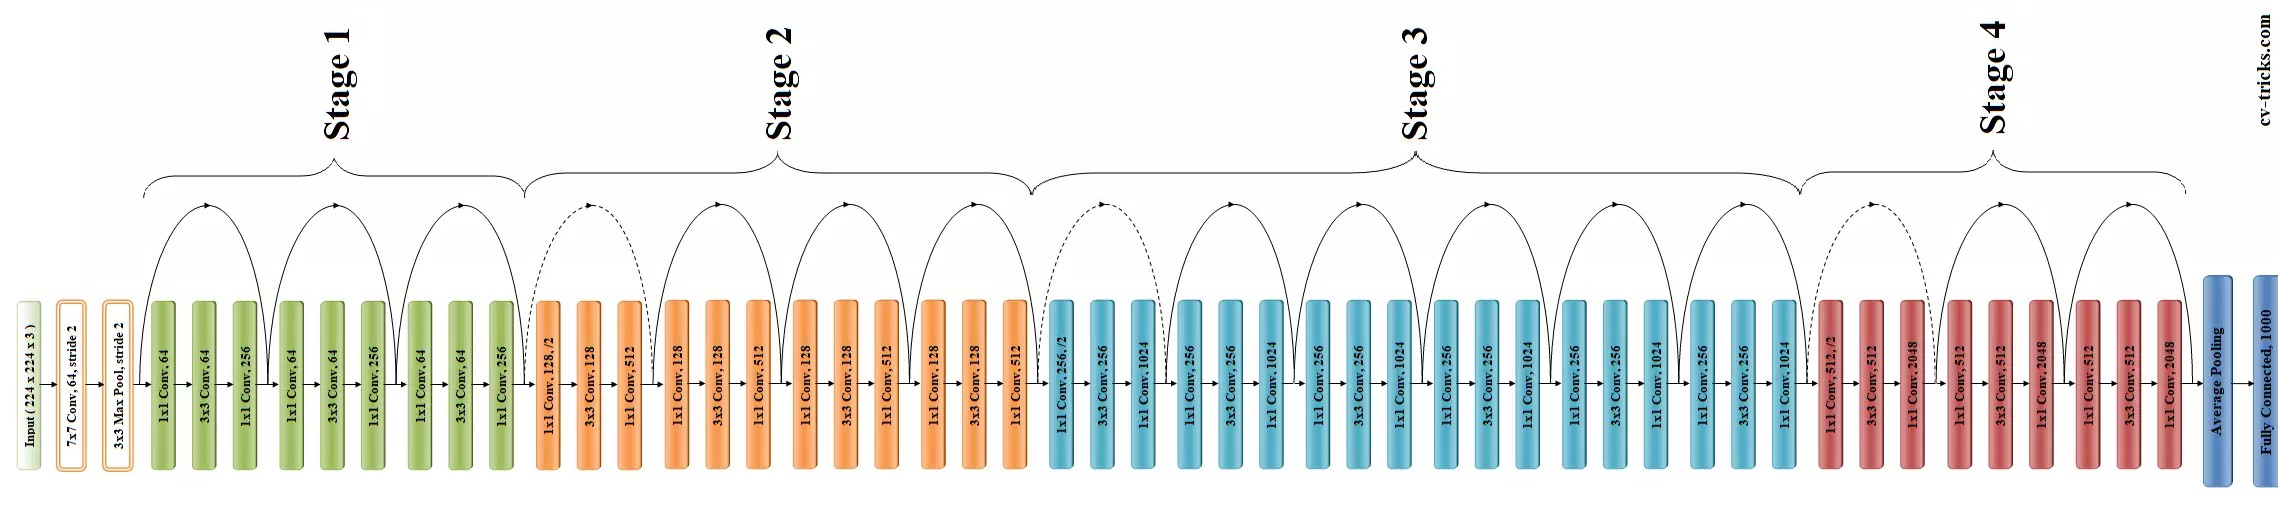

We tried different batch size and learning rate values for this model. For this model, we got the best validation accuracy when batch size value is 32 and the learning rate value is 0.01 .

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Epoch: 1 Train accuracy: 72.751 Validation accuracy: 82.392
Epoch: 2 Train accuracy: 83.200 Validation accuracy: 86.156
Epoch: 3 Train accuracy: 85.137 Validation accuracy: 88.575
Epoch: 4 Train accuracy: 86.276 Validation accuracy: 88.575
Epoch: 5 Train accuracy: 86.446 Validation accuracy: 90.726
Epoch: 6 Train accuracy: 86.817 Validation accuracy: 84.677
Epoch: 7 Train accuracy: 89.208 Validation accuracy: 89.651
Epoch: 8 Train accuracy: 88.639 Validation accuracy: 91.129
Epoch: 9 Train accuracy: 88.867 Validation accuracy: 90.726
Epoch: 10 Train accuracy: 88.753 Validation accuracy: 91.129
Epoch: 11 Train accuracy: 88.269 Validation accuracy: 89.651
Epoch: 12 Train accuracy: 88.753 Validation accuracy: 92.876
Epoch: 13 Train accuracy: 88.013 Validation accuracy: 89.651
Epoch: 14 Train accuracy: 87.842 Validation accuracy: 89.785
Epoch: 15 Train accuracy: 89.408 Validation accuracy: 90.591
Epoch: 16 Train accuracy: 88.554 Validation accuracy: 89.919
Epoch: 17 Train accuracy: 89.636

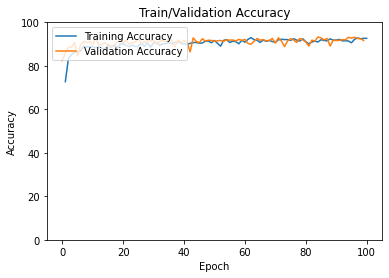

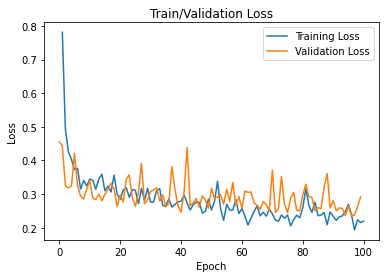

In [10]:
epoch = 100
learning_rate = 0.01

resnet_model = torchvision.models.resnet50(pretrained=True)
for param in resnet_model.parameters():
  param.requires_grad = False


num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 8)
resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr= learning_rate, momentum=0.9)
best_resnet_model_path = '/content/drive/MyDrive/BBM469-Project/best_resnet_model.pth'
train_acc, val_acc, train_loss, val_loss = train(resnet_model, epoch, criterion, optimizer_conv, best_resnet_model_path)
plot_accuracy_and_loss(train_acc, val_acc, train_loss, val_loss,epoch)

<h3>VGG16 </h3>

VGG16 is a CNN model consisting of small filter sizes, 13 convolution layers and 3 fully connected layers. We used the VGG16 model trained on ImageNet dataset.<br>
The structure of the VGG16 model is as follows.


<img src="notebook_img/vgg16_architecture.png" width="1000" height="200" alt="Resnet Connection">

We tried different batch size and learning rate values for this model. For this model, we got the best validation accuracy when batch size value is 32 and the learning rate value is 0.01 .

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Epoch: 1 Train accuracy: 65.290 Validation accuracy: 72.043
Epoch: 2 Train accuracy: 71.071 Validation accuracy: 73.790
Epoch: 3 Train accuracy: 73.719 Validation accuracy: 77.823
Epoch: 4 Train accuracy: 72.864 Validation accuracy: 78.898
Epoch: 5 Train accuracy: 74.146 Validation accuracy: 81.452
Epoch: 6 Train accuracy: 73.804 Validation accuracy: 75.806
Epoch: 7 Train accuracy: 74.829 Validation accuracy: 81.586
Epoch: 8 Train accuracy: 75.598 Validation accuracy: 84.274
Epoch: 9 Train accuracy: 75.313 Validation accuracy: 82.258
Epoch: 10 Train accuracy: 75.313 Validation accuracy: 78.360
Epoch: 11 Train accuracy: 75.171 Validation accuracy: 80.914
Epoch: 12 Train accuracy: 75.712 Validation accuracy: 81.855
Epoch: 13 Train accuracy: 76.395 Validation accuracy: 83.065
Epoch: 14 Train accuracy: 76.082 Validation accuracy: 80.914
Epoch: 15 Train accuracy: 75.911 Validation accuracy: 83.333
Epoch: 16 Train accuracy: 76.481 Validation accuracy: 81.989
Epoch: 17 Train accuracy: 77.249

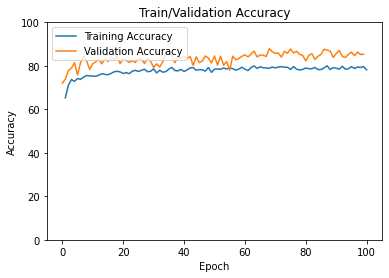

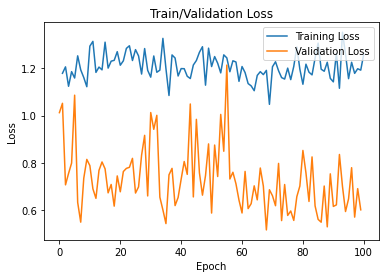

In [11]:
epoch = 100
learning_rate = 0.01

vgg16_model = torchvision.models.vgg16(pretrained=True)
for param in vgg16_model.parameters():
  param.requires_grad = False


num_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(num_features, 8)
vgg16_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, vgg16_model.parameters()), lr= learning_rate, momentum=0.9)
best_vgg16_model_path = '/content/drive/MyDrive/BBM469-Project/best_vgg16_model.pth'
train_acc, val_acc, train_loss, val_loss = train(vgg16_model, epoch, criterion, optimizer_conv, best_vgg16_model_path)
plot_accuracy_and_loss(train_acc, val_acc, train_loss, val_loss, epoch)

<h3>MobileNetV2 </h3>

MobileNetV2 is a CNN model developed for use in mobile devices. MobileNetV2 is based on an inverted residual block structure for efficiency reasons.<br>
We used MobileNetV2 model trained on ImageNet dataset.<br>
The structure of the MobileNetV2 model is as follows.

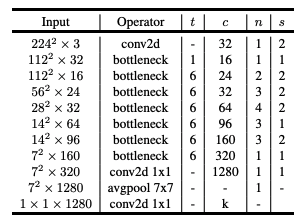

We tried different batch size and learning rate values for this model. For this model, we got the best validation accuracy when batch size value is 32 and the learning rate value is 0.01 .

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Epoch: 1 Train accuracy: 76.509 Validation accuracy: 86.694
Epoch: 2 Train accuracy: 83.685 Validation accuracy: 84.274
Epoch: 3 Train accuracy: 85.336 Validation accuracy: 87.097
Epoch: 4 Train accuracy: 85.222 Validation accuracy: 88.844
Epoch: 5 Train accuracy: 84.311 Validation accuracy: 85.349
Epoch: 6 Train accuracy: 86.219 Validation accuracy: 91.129
Epoch: 7 Train accuracy: 87.101 Validation accuracy: 89.113
Epoch: 8 Train accuracy: 88.069 Validation accuracy: 88.844
Epoch: 9 Train accuracy: 87.443 Validation accuracy: 87.769
Epoch: 10 Train accuracy: 87.984 Validation accuracy: 89.785
Epoch: 11 Train accuracy: 87.642 Validation accuracy: 88.172
Epoch: 12 Train accuracy: 88.610 Validation accuracy: 89.247
Epoch: 13 Train accuracy: 86.589 Validation accuracy: 87.366
Epoch: 14 Train accuracy: 86.418 Validation accuracy: 90.591
Epoch: 15 Train accuracy: 88.041 Validation accuracy: 88.038
Epoch: 16 Train accuracy: 87.215 Validation accuracy: 86.962
Epoch: 17 Train accuracy: 87.557

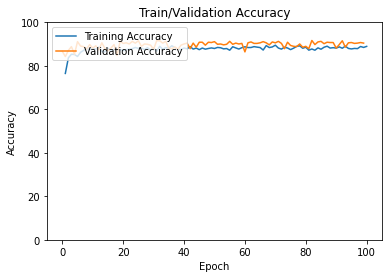

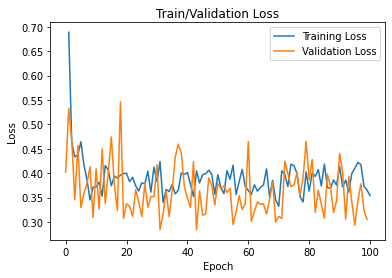

In [12]:
epoch = 100
learning_rate = 0.01

mobilenet = models.mobilenet_v2(pretrained=True)
    
for param in mobilenet.parameters():
  param.requires_grad = False

mobilenet.classifier[1] = nn.Linear(1280, 8)
mobilenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, mobilenet.parameters()), lr= learning_rate, momentum=0.9)
best_mobileNet_model_path = '/content/drive/MyDrive/BBM469-Project/best_mobileNet_model.pth'
tr_acc, val_acc, tr_loss, val_loss = train(mobilenet, epoch, criterion, optimizer_conv, best_mobileNet_model_path)
plot_accuracy_and_loss(tr_acc, val_acc, tr_loss, val_loss,epoch)

<h3>EfficientNet </h3>

EfficientNet is a CNN model that equally scales all depth, width, and resolution dimensions using a compound coefficient. EfficientNet consists of 8 different models between EfficientNet B0 and B7. While moving from B0 to B7, the number of parameters calculated and accuracy increases.
We used the pre-trained EfficentNet B3 model in our project.

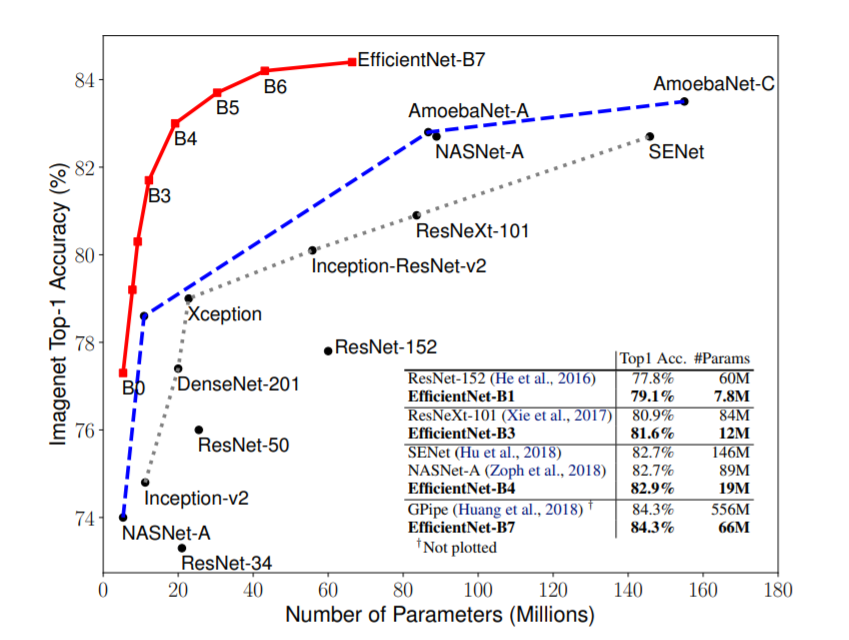

We tried different batch size and learning rate values for this model. For this model, we got the best validation accuracy when batch size value is 32 and the learning rate value is 0.001 .

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=f1fd0ec919bbe59bf9daae511a523eae6ad5812ce539fb43d557d4f441cd9133
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3
Epoch: 1 Train accuracy: 56.293 Validation accuracy: 77.957
Epoch: 2 Train accuracy: 80.040 Validation accuracy: 84.140
Epoch: 3 Train accuracy: 85.792 Validation accuracy: 88.038
Epoch: 4 Train accuracy: 88.440 Validation accuracy: 88.172
Epoch: 5 Train accuracy: 88.554 Validation accuracy: 88.978
Epoch: 6 Train accuracy: 90.091 Validation accuracy: 89.651
Epoch: 7 Train accuracy: 90.689 Validation accuracy: 90.860
Epoch: 8 Train accuracy: 91.714 Validation accuracy: 91.263
Epoch: 9 Train accuracy: 92.170 Validation accuracy: 92.204
Epoch: 10 Train accuracy: 93.451 Validation accuracy: 91.801
Epoch: 11 Train accuracy: 93.109 Validation accuracy: 92.608
Epoch: 12 Train accuracy: 93.650 Validation accuracy: 92.473
Epoch: 13 Train accuracy: 94.248 Validation accuracy: 92.876
Epoch: 14 Train accuracy: 93.964 Validation accuracy: 93.683
Epoch: 15 Train accuracy: 94.049 Validation accuracy: 94.086
Epoch: 16 Train accuracy: 94.106 Validation acc

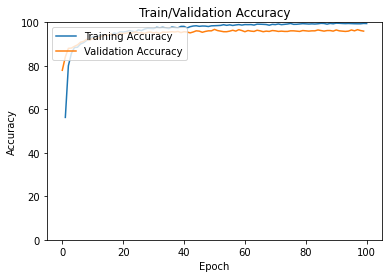

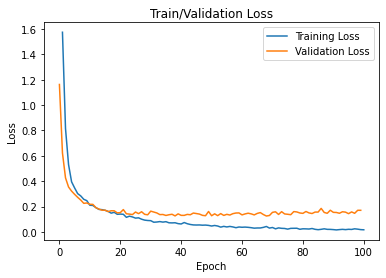

In [8]:
epoch = 100
learning_rate = 0.001

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=8)


efficientnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, efficientnet_model.parameters()), lr= learning_rate, momentum=0.9)
best_efficientNet_model_path = '/content/drive/MyDrive/BBM469-Project/best_efficientNet_model.pth'
tr_acc, val_acc, tr_loss, val_loss = train(efficientnet_model, epoch, criterion, optimizer_conv, best_efficientNet_model_path)
plot_accuracy_and_loss(tr_acc, val_acc, tr_loss, val_loss,epoch)

## Evaluation<a class="anchor" id="evaluation"></a>

While training the models we used, we saved the models with the highest validation accuracy. We tested the models we saved using the test dataset. We printed test accuracy and we plotted confusion matrix for each model. We calculated the accuracy using the ratio of correct predictions to total predictions. Finally, we compared the test accuracies we obtained using the graph we plotted.

<h5>Test Function</h5>

In [11]:
def test_data(cnnNetwork, loader):
  with torch.no_grad():
      cnnNetwork.eval()
      correct = 0.0
      total = 0.0
      conf_matrix_label = []
      conf_matrix_predict = []
      for i, (images, labels) in enumerate(loader):
          images, labels = images.to(device), labels.to(device)
          outputs = cnnNetwork(images)
          
          _, prediction = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (prediction == labels).sum().item()
          
          outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
          conf_matrix_predict.extend(outputs)  # Save Prediction
          labels = labels.data.cpu().numpy()
          conf_matrix_label.extend(labels)  # Save Truth

      accuracy = 100 * correct / total
      print("Test accuracy: ", accuracy)
      fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13, 10))
      class_names = ['TUMOR', 'STROMA', 'COMPLEX', 'LYMPHO', 'DEBRIS', 'MUCOSA', 'ADIPOSE', 'EMPTY']
      axes.set_title('Best Model Confusion Matrix', fontsize=20)
      cm = confusion_matrix(conf_matrix_label, conf_matrix_predict)
      sns.heatmap(cm, annot=True, fmt='g', ax=axes)
      axes.xaxis.set_ticklabels(class_names)
      axes.yaxis.set_ticklabels(class_names)
      plt.show()
      return accuracy

test_accuracies = []

<h4>Resnet50 Test Results</h4>

In [12]:
best_resnet_model_path = '/content/drive/MyDrive/BBM469-Project/best_resnet_model.pth'
best_vgg16_model_path = '/content/drive/MyDrive/BBM469-Project/best_vgg16_model.pth'
best_mobileNet_model_path = '/content/drive/MyDrive/BBM469-Project/best_mobileNet_model.pth'

Test accuracy:  91.61028416779432


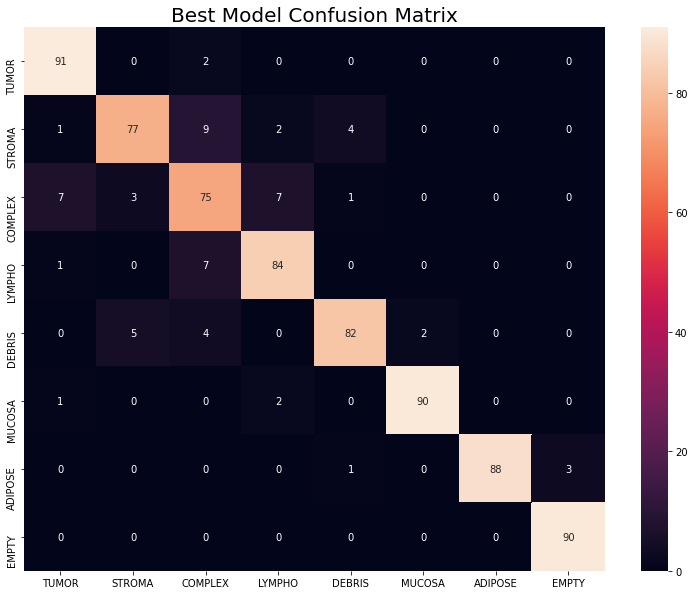

In [13]:
model = torch.load(best_resnet_model_path)
acc_resnet = test_data(model, testLoader)
test_accuracies.append(acc_resnet)

<h4>VGG16 Test Results</h4>

Test accuracy:  88.09201623815967


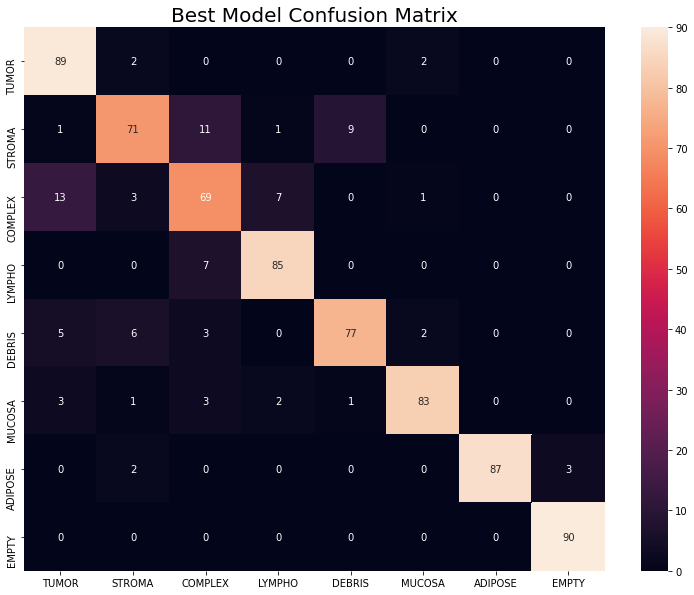

In [14]:
model = torch.load(best_vgg16_model_path)
acc_vgg = test_data(model, testLoader)
test_accuracies.append(acc_vgg)

<h4>MobileNetV2 Test Results</h4>

Test accuracy:  92.01623815967524


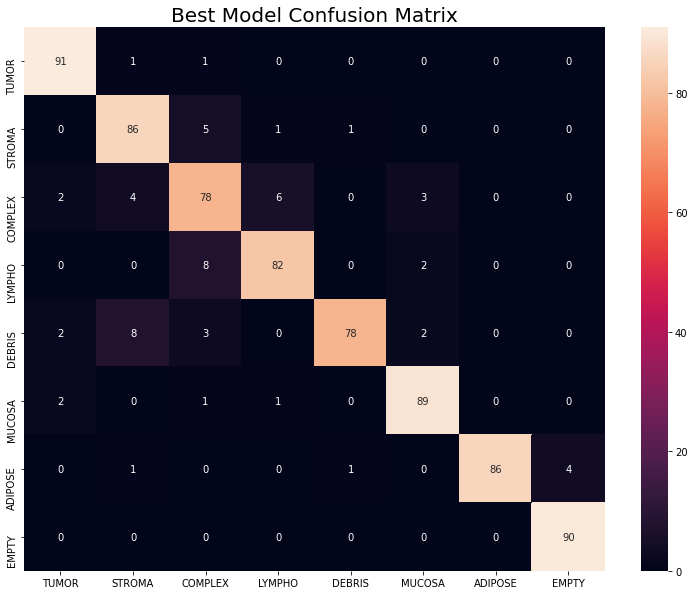

In [15]:
model = torch.load(best_mobileNet_model_path)
acc_mobileNet =test_data(model, testLoader)
test_accuracies.append(acc_mobileNet)

<h4>EfficientNet Test Results</h4>

Test accuracy:  96.07577807848443


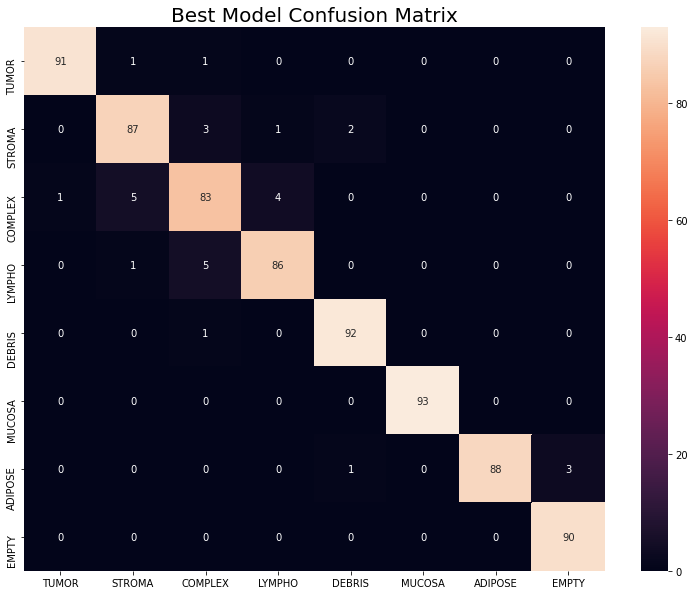

In [16]:
model = torch.load(best_efficientNet_model_path)
acc_efficientNet = test_data(model, testLoader)
test_accuracies.append(acc_efficientNet)

<h4>Model Comparison</h4>

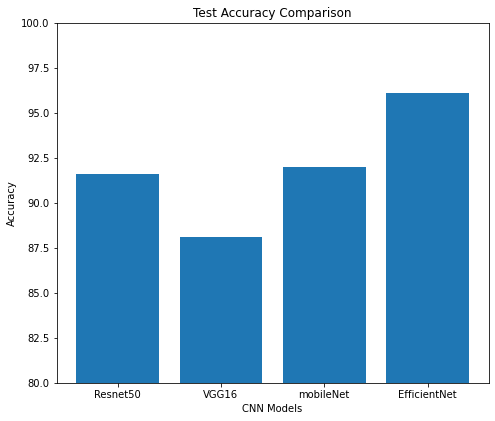

In [17]:
fig = plt.figure(figsize= (6,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Test Accuracy Comparison')

classification_methods = ['Resnet50', 'VGG16', 'mobileNet', 'EfficientNet']
ax.bar(classification_methods, test_accuracies)
ax.set(ylim=[80, 100])
ax.set_xlabel("CNN Models")
ax.set_ylabel("Accuracy")
plt.show()

In [18]:
for i in range(len(test_accuracies)):
  print(" Test Accuracy of " + classification_methods[i]+ " Model:", str(round(test_accuracies[i],3)) + '%'  )

 Test Accuracy of Resnet50 Model: 91.61%
 Test Accuracy of VGG16 Model: 88.092%
 Test Accuracy of mobileNet Model: 92.016%
 Test Accuracy of EfficientNet Model: 96.076%


According to the results we obtained, we got the best test accuracy in the EfficientNet-B3 model. The results we have obtained are compatible with the graph you see below.



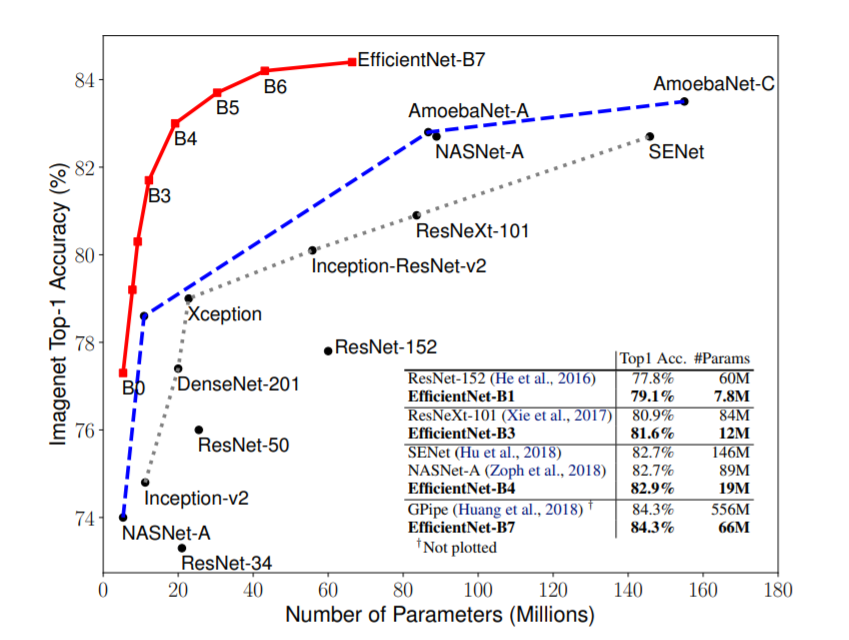

## References<a class="anchor" id="references"></a>

- https://www.kaggle.com/kmader/colorectal-histology-mnist
- https://cv-tricks.com/keras/understand-implement-resnets/
- https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
- https://kgptalkie.com/image-classification-using-pre-trained-vgg-16-model/
- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. Deep Residual Learning for Image Recognition - -(https://arxiv.org/pdf/1512.03385.pdf)
- Mark Sandler, Andrew Howard, Menglong Zhu, Andrey Zhmoginov, Liang-Chieh Chen. MobileNetV2: Inverted Residuals and Linear Bottlenecks(https://arxiv.org/pdf/1801.04381v4.pdf)
- Mingxing Tan, Quoc V. Le . EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (https://arxiv.org/pdf/1905.11946.pdf)
- https://github.com/lukemelas/EfficientNet-PyTorch
- https://pytorch.org/hub/pytorch_vision_resnet/
- https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484
- https://paperswithcode.com/method/residual-connection
- https://paperswithcode.com/method/efficientnet


**Disclaimer!** <font color='grey'>This notebook was prepared by Gökay Berkem TURAN and Zafer Can YÜCEL as a term project for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>